In [11]:
# %load main.py
import argparse
import time
import os
import os.path

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

import PIL
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import OrderedDict
from utility.utility import postp, GramMatrix, GramMSELoss, load_images, save_images, make_folders
from utility.vgg_network import VGG
from utility.loss_fns import get_patches, divide_patches, weight_maker, get_style_patch_weights, mrf_loss_fn

In [106]:
# style weights
sw1=1
sw2=1
sw3=1
sw4=1
sw5=1
# Content weights
cw1=0
cw2=0
cw3=0
cw4=1e5
cw5=0
#############################################################################
# Get image paths and names
# Style 1
style_dir1  = os.path.dirname('../input/font_contents/curvy_fonts/MrsSheppards-Regular.png')
style_name1 = os.path.basename('../input/font_contents/curvy_fonts/MrsSheppards-Regular.png')
# Style 2
s2 = '../input/photos/kyudai.jpg'
style_dir2 = os.path.dirname(s2)
style_name2 = os.path.basename(s2)
# style_dir2  = os.path.dirname('../input/font_contents/striped_curvy_fonts/MrsSheppards-Regular.png')
# style_name2 = os.path.basename('../input/font_contents/striped_curvy_fonts/MrsSheppards-Regular.png')
# Content
content_dir  = os.path.dirname('../input/font_contents/AlegreyaSans-Light/A.png')
content_name = os.path.basename('../input/font_contents/AlegreyaSans-Light/A.png')

# Cuda device
if torch.cuda.is_available:
    device = 'cuda:0'
else:
    device = 'cpu'
print("Using device: ", device)

# Parameters
alpha = 1
beta = 1
image_size = 256
content_invert = 1
style_invert = 1
result_invert = content_invert

# Get output path
output_path = '../output_style_difference/'
try:
    os.mkdir(output_path)
except:
    pass
output_path = output_path + content_name[:-4] + '_' + style_name1[:-4] + '_' + style_name2[:-4] + '/'

Using device:  cuda:0


In [107]:
# Get network
vgg = VGG()
vgg.load_state_dict(torch.load('../Models/vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.to(device)

# Load images
content_image = load_images(os.path.join(content_dir, content_name), image_size, device, content_invert)
style_image1  = load_images(os.path.join(style_dir1,style_name1), image_size, device, style_invert)
style_image2  = load_images(os.path.join(style_dir2,style_name2), image_size, device, style_invert)

# Random input
# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data).to(device), requires_grad=True).to(device)
# Content input
opt_img = Variable(content_image.data.clone(), requires_grad=True)

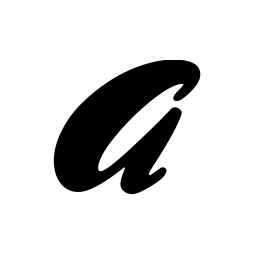

In [108]:
postp(style_image1.data[0].cpu().squeeze(), image_size, result_invert)

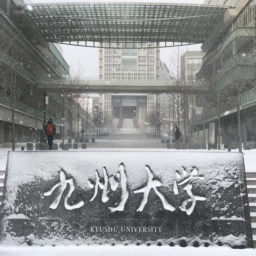

In [109]:
postp(style_image2.data[0].cpu().squeeze(), image_size, result_invert)

# Feature maps

In [110]:
def save_fms_one_layer_with_colorbar(fm, name, ncols):
    act = fm.squeeze()
    one_fig_size = 4
    nrows = int(act.size(0)/ncols)
    cmap = 'rainbow'
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(one_fig_size*ncols,one_fig_size*nrows))
    
    images = []
    for i,ax in enumerate(axes.flat):
        images.append(ax.imshow(act[i], cmap=cmap))
        ax.axis('off')
        ax.label_outer()
    
    vmin = act.min().item()
    vmax = act.max().item()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for img in images:
        img.set_norm(norm)

    fig.colorbar(images[0], ax=axes, orientation='horizontal', fraction=0.1)

    def update(changed_image):
        for im in images:
            if (changed_image.get_cmap() != im.get_cmap() or changed_image.get_clim() != im.get_clim()):
                im.set_cmap(changed_image.get_cmap())
                im.set_clim(changed_image.get_clim())

    for im in images:
        im.callbacksSM.connect('changed',update)

    plt.savefig(name)
    plt.close('all')

### Difference fms

In [111]:
layers = ['r12','r22','r32','r42','r52'] 
style1_fms = [A.detach() for A in vgg(style_image1, layers)]
style2_fms = [A.detach() for A in vgg(style_image2, layers)]
differ_fms = [A1-A2 for A1, A2 in zip(style1_fms,style2_fms)]

In [112]:
ncolss = [8,16,16,32,32]

In [113]:
# ncolss = [8,16,16,32,32]
for i,fm in enumerate(style1_fms):
    save_fms_one_layer_with_colorbar(fm,'fm_'+str(i+1),ncolss[i])

In [114]:
# ncolss = [8,16,16,32,32]
for i,fm in enumerate(style2_fms):
    save_fms_one_layer_with_colorbar(fm,'s2_fm_'+str(i+1),ncolss[i])

In [115]:
for i,fm in enumerate(differ_fms):
    save_fms_one_layer_with_colorbar(fm,'diff_fm_'+str(i+1),ncolss[i])

In [116]:
fm = style1_fms[0]

In [117]:
for i in range(5):
    print(style2_fms[i].min(), style2_fms[i].max())

tensor(0., device='cuda:0') tensor(2059.6755, device='cuda:0')
tensor(0., device='cuda:0') tensor(4963.8257, device='cuda:0')
tensor(0., device='cuda:0') tensor(5551.3076, device='cuda:0')
tensor(0., device='cuda:0') tensor(10444.6709, device='cuda:0')
tensor(0., device='cuda:0') tensor(714.4335, device='cuda:0')


In [118]:
for i in range(5):
    print(style1_fms[i].min(), style1_fms[i].max())

tensor(0., device='cuda:0') tensor(3225.6357, device='cuda:0')
tensor(0., device='cuda:0') tensor(8044.1816, device='cuda:0')
tensor(0., device='cuda:0') tensor(8224.8438, device='cuda:0')
tensor(0., device='cuda:0') tensor(15441.6914, device='cuda:0')
tensor(0., device='cuda:0') tensor(1075.5878, device='cuda:0')


In [119]:
for i in range(5):
    print(differ_fms[i].min(), differ_fms[i].max())

tensor(-2038.6816, device='cuda:0') tensor(3225.6357, device='cuda:0')
tensor(-4963.8257, device='cuda:0') tensor(8044.1816, device='cuda:0')
tensor(-4826.3535, device='cuda:0') tensor(8224.8438, device='cuda:0')
tensor(-9398.7432, device='cuda:0') tensor(13851.9619, device='cuda:0')
tensor(-714.4335, device='cuda:0') tensor(1075.5878, device='cuda:0')


In [120]:
def normalize0to1(fm):
    fm = (fm - fm.min())/(fm.max()-fm.min())
    return fm

In [121]:
fm.min(), fm.max()

(tensor(0., device='cuda:0'), tensor(3225.6357, device='cuda:0'))

In [122]:
for i in range(5):
    style1_fms[i] = normalize0to1(style1_fms[i])
    style2_fms[i] = normalize0to1(style2_fms[i])
    differ_fms[i] = normalize0to1(differ_fms[i])

In [123]:
# ncolss = [8,16,16,32,32]
for i,fm in enumerate(style1_fms):
    save_fms_one_layer_with_colorbar(fm,'n_fm_'+str(i+1),ncolss[i])

In [124]:
# ncolss = [8,16,16,32,32]
for i,fm in enumerate(style2_fms):
    save_fms_one_layer_with_colorbar(fm,'n_s2_fm_'+str(i+1),ncolss[i])

In [125]:
for i,fm in enumerate(differ_fms):
    save_fms_one_layer_with_colorbar(fm,'n_diff_fm_'+str(i+1),ncolss[i])

# Gram matrices

In [17]:
diff_gramm = [GramMatrix()(A) for A in differ_fms]
style1_gramm = [GramMatrix()(A) for A in style1_fms]
style2_gramm = [GramMatrix()(A) for A in style2_fms]
style_gramm = [A1-A2 for A1, A2 in zip(style1_gramm,style2_gramm)]

In [18]:
def visualize_gramm(gramm):
    cmap = 'rainbow'
    nrows = 3
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,26))

    images = []
    for i,ax in enumerate(axes.flat):
        if i == 5:
            images.append(ax.imshow(gramm[0].squeeze(), cmap=cmap))
        else:
            images.append(ax.imshow(gramm[i].squeeze(), cmap=cmap))
        ax.axis('off')
        ax.label_outer()

    vmin = min(gram.min().item() for gram in gramm)
    vmax = max(gram.max().item() for gram in gramm)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for img in images:
        img.set_norm(norm)

    fig.colorbar(images[0], ax=axes, orientation='horizontal', fraction=0.1)

    def update(changed_image):
        for im in images:
            if (changed_image.get_cmap() != im.get_cmap() or changed_image.get_clim() != im.get_clim()):
                im.set_cmap(changed_image.get_cmap())
                im.set_clim(changed_image.get_clim())

    for im in images:
        im.callbacksSM.connect('changed',update)

    plt.show()

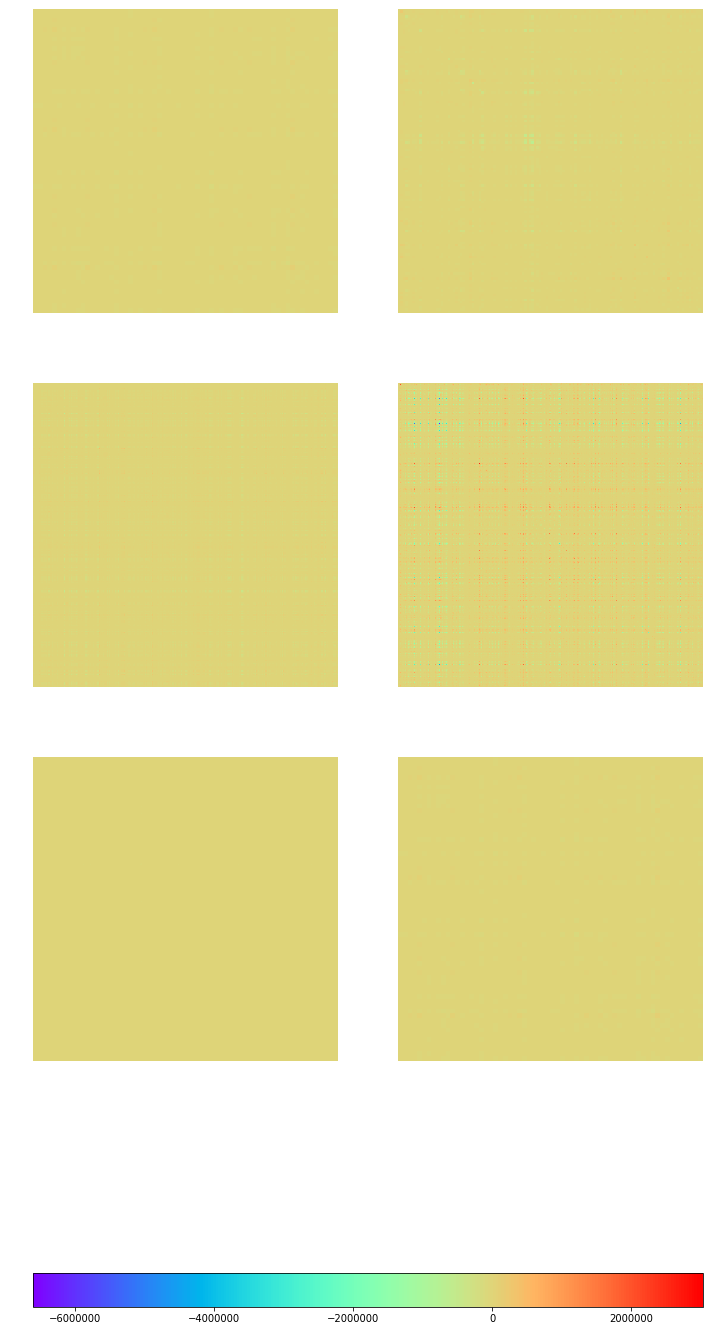

In [72]:
visualize_gramm(style_gramm)

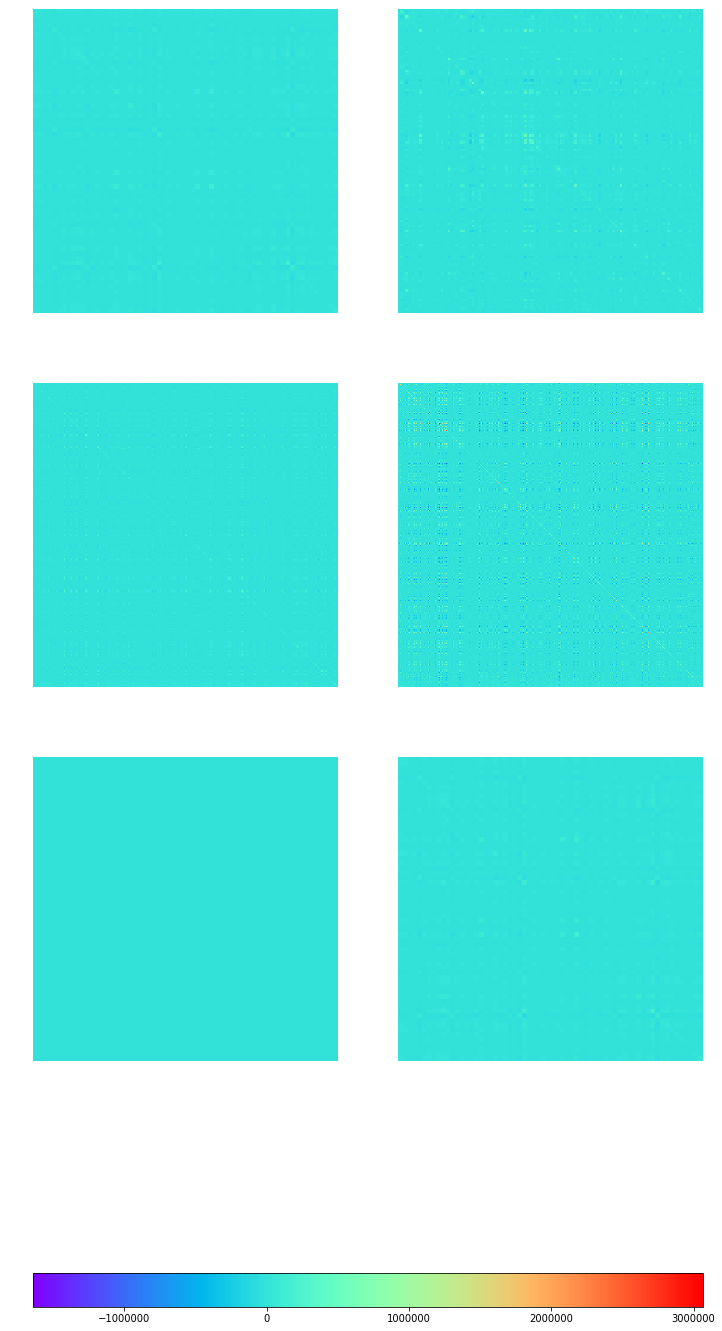

In [73]:
visualize_gramm(diff_gramm)